# **When Does Label Smoothing Help?**

Müller, R., Kornblith, S., & Hinton, G. (2019). When does label smoothing help?. arXiv preprint arXiv:1906.02629.

All experimental results are commited on Tensorboard Dev., and you can access below link:

*https://tensorboard.dev/experiment/XPL2o4vkS262ZVAPqhQeEQ/*

## **Default Setting**

In [ ]:
import tensorflow as tf

import time

import numpy as np
import pandas as pd

from adabelief_tf import AdaBeliefOptimizer
from matplotlib import pyplot as plt
from pathlib import Path

print(f"tf.__version__: {tf.__version__}")

tf.__version__: 2.4.1


In [ ]:
!nvidia-smi

Mon Apr 26 06:07:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Graphics Device     On   | 00000000:0A:00.0 Off |                  N/A |
|  0%   32C    P8    15W / 220W |     67MiB /  7979MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Graphics Device, compute capability 8.6


In [ ]:
# If you wanna avoid below error, you need to run below codes when you start kernel.

# UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, 
# so try looking to see if a warning log message was printed above. [Op:Conv2D]

# Ref: https://blog.naver.com/vft1500/221793591386

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs.")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs.


In [ ]:
class HParams(object):
    def __init__(self):
        self.seed = 42
        
        self.num_classes = 10
        
        self.vl_size = 10_000

        self.global_batch_size = 128
        self.buffer_size = 20_000
        self.auto = tf.data.experimental.AUTOTUNE

        self.image_size = [112, 112]
        
        self.student_growth_rate = 12
        self.teacher_growth_rate = 32

        self.init_lr = 1e-3
        self.epochs = 10
        
        self.steps_per_epoch = None
        self.validation_steps = None
        self.steps_per_execution = 16
        
        self.ts_factor = 1.5
        self.ls_factor = 0.1

HPARAMS = HParams()

## **Prepare Dataset**

In [ ]:
@tf.function
def resizing_and_rescaling(images, labels):
    images = tf.expand_dims(images, axis = -1)
    images = tf.image.convert_image_dtype(images, tf.float32)
    images = tf.image.resize(images, HPARAMS.image_size)
    # images = tf.image.grayscale_to_rgb(images)
    labels = tf.one_hot(labels, depth = HPARAMS.num_classes)
    return images, labels


def get_shapes(element_spec):
    return [get_shapes(e) if isinstance(e, tuple) else e.shape for e in element_spec]

In [ ]:
def get_dataset(
    batch_size = HPARAMS.global_batch_size
):
    ## Load dataset from tfds.
    (tr_X, tr_Y), (ts_X, ts_Y) = tf.keras.datasets.mnist.load_data()

    ## Train test split.
    tr_X, vl_X = tr_X[HPARAMS.vl_size:], tr_X[:HPARAMS.vl_size]
    tr_Y, vl_Y = tr_Y[HPARAMS.vl_size:], tr_Y[:HPARAMS.vl_size]

    ## Building.
    tr_ds = tf.data.Dataset.from_tensor_slices((tr_X, tr_Y)
                ).cache(
                ).repeat(
                ).shuffle(HPARAMS.buffer_size, reshuffle_each_iteration = True,
                ).batch(batch_size
                ).map(resizing_and_rescaling, num_parallel_calls = HPARAMS.auto
                ).prefetch(HPARAMS.auto)
    
    vl_ds = tf.data.Dataset.from_tensor_slices((vl_X, vl_Y)
                ).cache(
                ).repeat(
                # ).shuffle(HPARAMS.buffer_sz, reshuffle_each_iteration = True,
                ).batch(batch_size
                ).map(resizing_and_rescaling, num_parallel_calls = HPARAMS.auto
                ).prefetch(HPARAMS.auto)

    ts_ds = tf.data.Dataset.from_tensor_slices((ts_X, ts_Y)
                ).cache(
                # ).shuffle(HPARAMS.buffer_size, reshuffle_each_iteration = True,
                ).batch(batch_size
                ).map(resizing_and_rescaling, num_parallel_calls = HPARAMS.auto
                ).prefetch(HPARAMS.auto)

    steps_per_epoch  = np.ceil(np.shape(tr_X)[0] / batch_size)
    validation_steps = np.ceil(np.shape(vl_Y)[0] / batch_size)
    
    HPARAMS.steps_per_epoch  = steps_per_epoch
    HPARAMS.validation_steps = validation_steps
    
    print(f"# of training data: {tr_X.shape[0]}")
    print(f"# of validation data: {vl_X.shape[0]}")
    print(f"# of test data: {ts_X.shape[0]}\n")

    print(f"Global batch size: {batch_size}")
    print(f"Steps per epoch: {steps_per_epoch} (total {steps_per_epoch * HPARAMS.epochs} batches)")
    print(f"Validation steps: {validation_steps} (total {validation_steps * HPARAMS.epochs} batches)\n")
    
    print(f"Steps per execution: {HPARAMS.steps_per_execution}\n")

    print(f"tr_ds.element_spec: {get_shapes(tr_ds.element_spec)}")
    print(f"vl_ds.element_spec: {get_shapes(vl_ds.element_spec)}")
    print(f"ts_ds.element_spec: {get_shapes(ts_ds.element_spec)}\n")

    return tr_ds, vl_ds, ts_ds

## **Modeling**

### **Baseline**

In [ ]:
def bn_ReLU_conv2D(x, filters, kernel_size):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.nn.relu6)(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding = "same")(x)
    
    return x


def transition_block(x):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(x.shape[-1] // 2, 1, padding = "same")(x)
    x = tf.keras.layers.AveragePooling2D((2, 2), strides = 2)(x)

    return x


def dense_block(x, num_conv, growth_rate):
    for i in range(num_conv):
        residual = x
        x = bn_ReLU_conv2D(x, 4 * growth_rate, 1)
        x = bn_ReLU_conv2D(x, growth_rate, 3)
        x = tf.keras.layers.Concatenate(axis = -1)([x, residual])

    return x

In [ ]:
def create_NN(
    model_name, 
    growth_rate = HPARAMS.teacher_growth_rate, 
    embedding_dim = HPARAMS.num_classes,
    temperature_scaling = 1,
):
    ## DenseNet-121
    x = model_input = tf.keras.layers.Input(shape = (*HPARAMS.image_size, 1)) ## grayscale, not rgb

    ## Entry Flow
    x = tf.keras.layers.Conv2D(2 * growth_rate, 7, strides = 2, padding = "same")(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides = 2, padding = "same")(x)


    ## Middle Flow
    for i, num_conv in enumerate([6, 12, 24, 16]):
        x = dense_block(x, num_conv, growth_rate)
        if i is not 3: 
            x = transition_block(x)

    ## Exit Flow
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(embedding_dim)(x)
    ## Temperature scaling.
    x = tf.keras.layers.Lambda(lambda x: tf.math.divide(x, temperature_scaling))(x)
    
    model_output = x = tf.keras.layers.Activation("linear", dtype = tf.float32)(x) ## no classifier!

    return tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name
    )

In [ ]:
# tmp = create_NN("tmp")
# tmp.summary()

In [ ]:
# del tmp

### **Teacher and Student Model**

In [ ]:
class DistillationModelWrapper(tf.keras.Model):
    def __init__(
        self, 
        teacher, 
        student, 
        **kwargs
    ):
        super(DistillationModelWrapper, self).__init__(**kwargs)
        ## Assert teacher and Student have no classification layer (i.e. softmax).
        self.teacher = teacher
        self.student = student
        
    def compile(
        self, 
        optimizer,
        student_loss_fn,
        distillation_loss_fn,
        metrics,
        alpha = 0.6,
        temperature = 10,
        **kwargs,
    ):
        super(DistillationModelWrapper, self).compile(
            optimizer = optimizer,
            metrics = metrics,
            **kwargs
        )
        # self.optimizer = optimizer
        self.student_loss_fn = student_loss_fn ## sparse categorical crossentropy
        self.distillation_loss_fn = distillation_loss_fn ## Kullback–Leibler divergence
        # self.metrics = metrics ## accuracy
        self.alpha = alpha
        self.temperature = temperature
        
    @tf.function
    def train_step(self, x):
        inp, tar = x

        teacher_pred = self.teacher(inp, training = False)
        
        with tf.GradientTape() as tape:
            student_pred = self.student(inp)
            
            ## Calculate losses.
            student_loss = self.student_loss_fn(
                tar, 
                student_pred,
            )
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_pred / self.temperature),
                tf.nn.softmax(student_pred / self.temperature),
            )
            
            loss = (1. - self.alpha) * student_loss + self.alpha * distillation_loss
            scaled_loss = self.optimizer.get_scaled_loss(loss)
            
        scaled_grads = tape.gradient(scaled_loss, self.student.trainable_variables)
        grads = self.optimizer.get_unscaled_gradients(scaled_grads)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_weights))

        self.compiled_metrics.update_state(tar, student_pred)
        
        results = {"loss": student_loss, "dist_loss": distillation_loss}
        results.update({m.name: m.result() for m in self.metrics})
        
        return results
    
    @tf.function
    def test_step(self, x):
        inp, tar = x
        
        teacher_pred = self.teacher(inp, training = False)
        student_pred = self.student(inp, training = False)
        
        student_loss = self.student_loss_fn(
            tar, 
            student_pred,
        )
        distillation_loss = self.distillation_loss_fn(
            tf.nn.softmax(teacher_pred / self.temperature),
            tf.nn.softmax(student_pred / self.temperature),
        )
        
        loss = (1. - self.alpha) * student_loss + self.alpha * distillation_loss
        
        self.compiled_metrics.update_state(tar, student_pred)
        
        results = {"loss": student_loss, "dist_loss": distillation_loss}
        results.update({m.name: m.result() for m in self.metrics})
        
        return results

### **Compiled Models**

In [ ]:
def get_compiled_baseline(
    model_name,
    growth_rate,
    temperature_scaling_factor = 1,
    label_smoothing_factor = 0,
):  
    model = create_NN(
        model_name = model_name,
        growth_rate = growth_rate,
        temperature_scaling = temperature_scaling_factor,
    )

    model.compile(
        optimizer = tf.keras.mixed_precision.LossScaleOptimizer(
            AdaBeliefOptimizer(
                learning_rate = HPARAMS.init_lr, 
                epsilon = 1e-14,
                weight_decay = 1e-5,
                rectify = True,
                print_change_log = False,
            ),
        ),
        loss = tf.keras.losses.CategoricalCrossentropy(
            from_logits = True,
            label_smoothing = label_smoothing_factor,
        ),
        metrics = [tf.keras.metrics.CategoricalAccuracy(name = "acc")],
        steps_per_execution = HPARAMS.steps_per_execution,
    )
    
    return model


def get_compiled_distiller(
    teacher,
    model_name = "distiller",
):  
    teacher.trainable = False ## freeze
    
    model = DistillationModelWrapper(
        teacher = teacher,
        student = create_NN(
            f"{model_name}-student", 
            growth_rate = HPARAMS.student_growth_rate
        ),
        name = model_name,
    )

    model.compile(
        optimizer = tf.keras.mixed_precision.LossScaleOptimizer(
            AdaBeliefOptimizer(
                learning_rate = HPARAMS.init_lr, 
                epsilon = 1e-14,
                weight_decay = 1e-5,
                rectify = True,
                print_change_log = False,
            ),
        ),
        student_loss_fn = tf.keras.losses.CategoricalCrossentropy(
            from_logits = True,
            ## We do not want to apply label smoothing in distiller.
        ),
        distillation_loss_fn = tf.keras.losses.KLDivergence(),
        metrics = [tf.keras.metrics.CategoricalAccuracy(name = "acc")],
        steps_per_execution = HPARAMS.steps_per_execution,
    )
    
    return model

## **Fit**

### **Callbacks**

In [ ]:
def get_callbacks(
    model_name
):
    ## Checkpoint callback.
    ckpt_path = Path(f"ckpt/{model_name}/" + "cp-{epoch:03d}-{val_loss:.4f}.ckpt")
    ckpt_path.parent.mkdir(parents = True, exist_ok = True)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, 
        verbose = 0, 
        monitor = "val_loss", 
        save_weights_only = True, 
        save_best_only = True,
    )

    ## TensorBoard callback.
    log_dir = Path(f"logs/fit/{model_name}")
    tb_callback = tf.keras.callbacks.TensorBoard(
        log_dir = log_dir, 
        histogram_freq = 1,
    )
    
    ## CSV Logger.
    filename = Path(f"logs/csv/{model_name}.csv")
    filename.parents[0].mkdir(parents = True, exist_ok = True)
    
    lg_callback = tf.keras.callbacks.CSVLogger(filename)

    return [cp_callback, tb_callback, lg_callback]

### **Checkpoints**

In [ ]:
def load_latest_checkpoint(
    ckpt_folder, 
    growth_rate = HPARAMS.teacher_growth_rate, 
    is_distiller = False,
):
    latest = tf.train.latest_checkpoint(ckpt_folder)
    print(f"Load latest checkpoints: {latest}...")
    
    model_name = ckpt_folder.split("/")[-1]
    
    if is_distiller:
        model = DistillationModelWrapper(
            teacher = create_NN(f"{model_name}-teacher-latest", growth_rate = HPARAMS.teacher_growth_rate),
            student = create_NN(f"{model_name}-student-latest", growth_rate = HPARAMS.student_growth_rate),
        )

        ckpt = tf.train.Checkpoint(model)
        ckpt.restore(latest).expect_partial()
        
        model = model.student
    else:
        model = create_NN(
            model_name = f"{model_name}-latest",
            growth_rate = growth_rate,
        )
        
        ckpt = tf.train.Checkpoint(model)
        ckpt.restore(latest).expect_partial()

    ## Compile
    model.compile(
        optimizer = tf.keras.mixed_precision.LossScaleOptimizer(
            AdaBeliefOptimizer(
                learning_rate = HPARAMS.init_lr, 
                epsilon = 1e-14,
                weight_decay = 1e-5,
                rectify = False,
                print_change_log = False,
            ),
        ),
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
        metrics = [tf.keras.metrics.CategoricalAccuracy(name = "acc")],
        steps_per_execution = HPARAMS.steps_per_execution,
    )
    
    return model

### **Teachers**

* Baseline Teacher

* Temperature Scaled Teacher

* Label Smoothed Teacher

In [ ]:
!rm -rf logs
!rm -rf ckpt

In [ ]:
tr_ds, vl_ds, ts_ds = get_dataset()

# of training data: 50000
# of validation data: 10000
# of test data: 10000

Global batch size: 128
Steps per epoch: 391.0 (total 3910.0 batches)
Validation steps: 79.0 (total 790.0 batches)

Steps per execution: 16

tr_ds.element_spec: [TensorShape([None, 112, 112, 1]), TensorShape([None, 10])]
vl_ds.element_spec: [TensorShape([None, 112, 112, 1]), TensorShape([None, 10])]
ts_ds.element_spec: [TensorShape([None, 112, 112, 1]), TensorShape([None, 10])]



In [ ]:
%%time
teachers = {}

teacher_args = [
    ("bs-teacher", HPARAMS.teacher_growth_rate, 1, 0),
    ("ts-teacher", HPARAMS.teacher_growth_rate, HPARAMS.ts_factor, 0),
    ("ls-teacher", HPARAMS.teacher_growth_rate, 1, HPARAMS.ls_factor),
]

for (model_name, growth_rate, ts_factor, ls_factor) in teacher_args:
    ## Record working time.
    start = time.time()
    
    model = get_compiled_baseline(
        model_name = model_name,
        growth_rate = growth_rate,
        temperature_scaling_factor = ts_factor,
        label_smoothing_factor = ls_factor,
    )
    
    print(f"Training model: {model.name}...")

    _ = model.fit(
        tr_ds,
        validation_data = vl_ds,
        steps_per_epoch = HPARAMS.steps_per_epoch,
        validation_steps = HPARAMS.validation_steps,
        epochs = HPARAMS.epochs,
        verbose = 2,
        callbacks = get_callbacks(model.name),
    )
    
    model.trainable = False
    teachers[model.name] = model
    
    print()
    # print(f"   - Time taken: {start - time.time():.2f}s \n")

Training model: bs-teacher...
Epoch 1/10
391/391 - 180s - loss: 0.1858 - acc: 0.9448 - val_loss: 4.8045 - val_acc: 0.1366
Epoch 2/10
391/391 - 83s - loss: 0.0522 - acc: 0.9840 - val_loss: 3.5927 - val_acc: 0.5045
Epoch 3/10
391/391 - 83s - loss: 0.0429 - acc: 0.9875 - val_loss: 0.9627 - val_acc: 0.8310
Epoch 4/10
391/391 - 82s - loss: 0.0397 - acc: 0.9881 - val_loss: 0.2000 - val_acc: 0.9448
Epoch 5/10
391/391 - 83s - loss: 0.0329 - acc: 0.9901 - val_loss: 0.0771 - val_acc: 0.9780
Epoch 6/10
391/391 - 83s - loss: 0.0338 - acc: 0.9903 - val_loss: 0.2553 - val_acc: 0.9396
Epoch 7/10
391/391 - 83s - loss: 0.0275 - acc: 0.9914 - val_loss: 0.1618 - val_acc: 0.9598
Epoch 8/10
391/391 - 83s - loss: 0.0265 - acc: 0.9919 - val_loss: 0.1590 - val_acc: 0.9567
Epoch 9/10
391/391 - 84s - loss: 0.0260 - acc: 0.9919 - val_loss: 0.0878 - val_acc: 0.9808
Epoch 10/10
391/391 - 85s - loss: 0.0246 - acc: 0.9924 - val_loss: 0.1227 - val_acc: 0.9739

Training model: ts-teacher...
Epoch 1/10
391/391 - 174s -

In [ ]:
%%time
latest_teachers = {}

for teacher_name, teacher in teachers.items():
    latest_teacher = load_latest_checkpoint(
        f"./ckpt/{teacher_name}", 
        growth_rate = HPARAMS.teacher_growth_rate
    )
    
    loss, acc = latest_teacher.evaluate(ts_ds, verbose = 0)
    print(f"   - Loss: {loss:.4f}, Accuracy: {acc:.4f}\n")
    
    latest_teachers[teacher_name] = latest_teacher

Load latest checkpoints: ./ckpt/bs-teacher/cp-005-0.0771.ckpt...
   - Loss: 0.0746, Accuracy: 0.9791

Load latest checkpoints: ./ckpt/ts-teacher/cp-010-0.0310.ckpt...
   - Loss: 0.0379, Accuracy: 0.9919

Load latest checkpoints: ./ckpt/ls-teacher/cp-004-0.5397.ckpt...
   - Loss: 0.1461, Accuracy: 0.9901

CPU times: user 21.7 s, sys: 369 ms, total: 22 s
Wall time: 23.4 s


### **Baseline Student**

In [ ]:
students = {}

In [ ]:
%%time

student_args = [
    ("bs-student", HPARAMS.student_growth_rate, 1, 0),
]

for (model_name, growth_rate, ts_factor, ls_factor) in student_args:
    ## Record working time.
    start = time.time()
    
    model = get_compiled_baseline(
        model_name = model_name,
        growth_rate = growth_rate,
        temperature_scaling_factor = ts_factor,
        label_smoothing_factor = ls_factor,
    )
    
    print(f"Training model: {model.name}...")

    _ = model.fit(
        tr_ds,
        validation_data = vl_ds,
        steps_per_epoch = HPARAMS.steps_per_epoch,
        validation_steps = HPARAMS.validation_steps,
        epochs = HPARAMS.epochs,
        verbose = 2,
        callbacks = get_callbacks(model.name),
    )
    
    model.trainable = False
    students[model.name] = model
    
    print()
    # print(f"   - Time taken: {start - time.time():.2f}s \n")

Training model: bs-student...
Epoch 1/10
391/391 - 151s - loss: 0.2902 - acc: 0.9179 - val_loss: 1.1420 - val_acc: 0.5768
Epoch 2/10
391/391 - 56s - loss: 0.0472 - acc: 0.9849 - val_loss: 0.1725 - val_acc: 0.9526
Epoch 3/10
391/391 - 56s - loss: 0.0364 - acc: 0.9888 - val_loss: 0.0980 - val_acc: 0.9733
Epoch 4/10
391/391 - 56s - loss: 0.0308 - acc: 0.9903 - val_loss: 0.2839 - val_acc: 0.9144
Epoch 5/10
391/391 - 56s - loss: 0.0266 - acc: 0.9912 - val_loss: 0.0378 - val_acc: 0.9897
Epoch 6/10
391/391 - 56s - loss: 0.0260 - acc: 0.9921 - val_loss: 0.2813 - val_acc: 0.9259
Epoch 7/10
391/391 - 56s - loss: 0.0198 - acc: 0.9938 - val_loss: 0.0467 - val_acc: 0.9877
Epoch 8/10
391/391 - 56s - loss: 0.0247 - acc: 0.9922 - val_loss: 0.0444 - val_acc: 0.9859
Epoch 9/10
391/391 - 57s - loss: 0.0188 - acc: 0.9941 - val_loss: 0.0520 - val_acc: 0.9862
Epoch 10/10
391/391 - 56s - loss: 0.0191 - acc: 0.9937 - val_loss: 0.0928 - val_acc: 0.9734

CPU times: user 10min 25s, sys: 23.5 s, total: 10min 48s


### **Distilled Students**

In [ ]:
%%time

distilled_student_args = [
    ("bs-distilled-student", "bs-teacher", HPARAMS.student_growth_rate, 1, 0),
    ("ts-distilled-student", "ts-teacher", HPARAMS.student_growth_rate, 1, 0),
    ("ls-distilled-student", "ls-teacher", HPARAMS.student_growth_rate, 1, 0),
]

for (model_name, teacher_name, growth_rate, ts_factor, ls_factor) in distilled_student_args:
    ## Record working time.
    start = time.time()
    
    model = get_compiled_distiller(
        teacher = teachers[teacher_name],
        model_name = model_name,
    )
    
    print(f"Training model: {model.name}...")

    _ = model.fit(
        tr_ds,
        validation_data = vl_ds,
        steps_per_epoch = HPARAMS.steps_per_epoch,
        validation_steps = HPARAMS.validation_steps,
        epochs = HPARAMS.epochs,
        verbose = 2,
        callbacks = get_callbacks(model.name),
    )
    
    model.student.trainable = False
    students[model.name] = model.student ## only take partial of the model (student)
    
    print()
    # print(f"   - Time taken: {start - time.time():.2f}s \n")

Training model: bs-distilled-student...
Epoch 1/10
391/391 - 143s - loss: 0.1024 - dist_loss: 0.1106 - acc: 0.7597 - val_loss: 0.2968 - val_dist_loss: 0.1105 - val_acc: 0.9567
Epoch 2/10
391/391 - 69s - loss: 0.1088 - dist_loss: 0.0658 - acc: 0.9632 - val_loss: 0.1306 - val_dist_loss: 0.0568 - val_acc: 0.9763
Epoch 3/10
391/391 - 68s - loss: 0.0986 - dist_loss: 0.0588 - acc: 0.9785 - val_loss: 0.0086 - val_dist_loss: 0.0454 - val_acc: 0.9813
Epoch 4/10
391/391 - 68s - loss: 0.0048 - dist_loss: 0.0366 - acc: 0.9825 - val_loss: 0.0690 - val_dist_loss: 0.0420 - val_acc: 0.9820
Epoch 5/10
391/391 - 70s - loss: 0.0134 - dist_loss: 0.0257 - acc: 0.9882 - val_loss: 0.0203 - val_dist_loss: 0.0266 - val_acc: 0.9886
Epoch 6/10
391/391 - 70s - loss: 0.0412 - dist_loss: 0.0406 - acc: 0.9890 - val_loss: 0.0647 - val_dist_loss: 0.0435 - val_acc: 0.9840
Epoch 7/10
391/391 - 71s - loss: 0.0020 - dist_loss: 0.0240 - acc: 0.9906 - val_loss: 0.0378 - val_dist_loss: 0.0271 - val_acc: 0.9884
Epoch 8/10
391

In [ ]:
%%time
latest_students = {}

for student_name, student in students.items():
    if student_name == "bs-student":
        latest_student = load_latest_checkpoint(
            f"./ckpt/{student_name}", 
            growth_rate = HPARAMS.student_growth_rate
        )
    else:
        latest_student = load_latest_checkpoint(
            f"./ckpt/{student_name}", 
            is_distiller = True,
        )
    
    loss, acc = latest_student.evaluate(ts_ds, verbose = 0)
    print(f"   - Loss: {loss:.4f}, Accuracy: {acc:.4f}\n")
    
    latest_students[student_name] = latest_student

Load latest checkpoints: ./ckpt/bs-student/cp-005-0.0378.ckpt...
   - Loss: 0.0293, Accuracy: 0.9913

Load latest checkpoints: ./ckpt/bs-distilled-student/cp-008-0.0039.ckpt...
   - Loss: 0.0437, Accuracy: 0.9878

Load latest checkpoints: ./ckpt/ts-distilled-student/cp-010-0.0011.ckpt...
   - Loss: 0.0338, Accuracy: 0.9887

Load latest checkpoints: ./ckpt/ls-distilled-student/cp-009-0.0164.ckpt...
   - Loss: 0.0266, Accuracy: 0.9937

CPU times: user 38.3 s, sys: 257 ms, total: 38.5 s
Wall time: 36.8 s


## **Visualize All Logs**

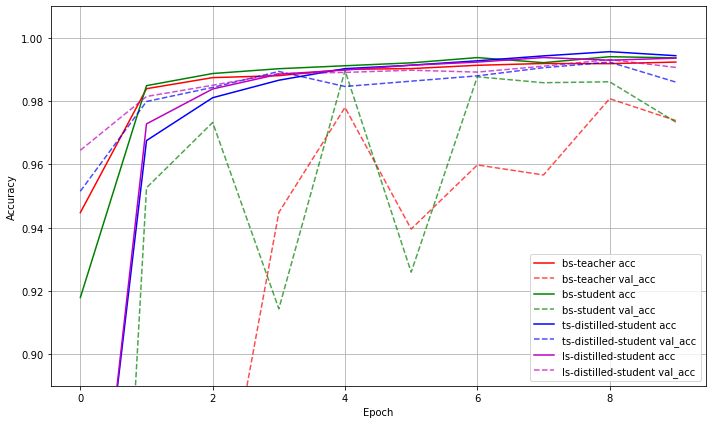

In [ ]:
log_path = Path("./logs/csv")
log_names = ["bs-teacher.csv", 
             "bs-student.csv",
             "ts-distilled-student.csv",
             "ls-distilled-student.csv"]
logs = [pd.read_csv(log_path / Path(log_name)) for log_name in log_names]
                    
plt.figure(figsize = (10, 6), facecolor = "white")

for log_name, log, color in zip(log_names, logs, ["r", "g", "b", "m"]):
    label = log_name.split(".")[0]
    
    plt.plot(log.acc, c = color, label = f"{label} acc")
    plt.plot(log.val_acc, c = color, alpha = 0.7, ls = "--", label = f"{label} val_acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.89, 1.01])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## **Commit to Tensorboard Dev.**

In [ ]:
!tensorboard dev upload --logdir ./logs/fit \
    --name "Experiment of 'When Does Label Smoothing Help?'" \
    --description "Implemented training results from the paper 'https://arxiv.org/abs/1906.02629'" \
    --one_shot

In [3]:
from IPython import display

display.IFrame(
    src = "https://tensorboard.dev/experiment/XPL2o4vkS262ZVAPqhQeEQ/",
    width = "100%",
    height = "1000px"
)